In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
import seaborn as sns 

import warnings
warnings.filterwarnings('ignore')


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

pd.set_option('display.max_columns', None)

In [2]:
categorical = pd.read_csv('categorical.csv')
numerical = pd.read_csv('numerical.csv')
targets = pd.read_csv('target.csv')

In [3]:
all_data = pd.concat([categorical,numerical,targets],axis=1)
all_data.shape

(95412, 339)

In [4]:
X = all_data.drop(['TARGET_B','TARGET_D','RFA_2R'],axis=1)
y_B = all_data[['TARGET_B']]
y_D = all_data[['TARGET_D']]

In [5]:
def ready_dfs(X,y):
    # * Split the data into a training set and a test set.
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    #split numericals - categoricals
    X_train_num = X_train.select_dtypes(np.number)
    X_test_num = X_test.select_dtypes(np.number)
    
    X_train_cat = X_train.select_dtypes(object)
    X_test_cat = X_test.select_dtypes(object)
    
    # I will join  'DATASRCE','DOMAIN_B' to the categoricals dataframe
    # I will keep CLUSTER and CLUSTER2 in the numericals because there are too many of them to encode
    # I will drop TCODE because it is a categorical column with lots of different values and it will be hard to encode, if I had the time maybe I could encode it but it's too large
    # I will drop DOB_YR and DOB_MM because I already have a column for the age
    # I will keep RFA_2F in the numericals because I can't find it's meaning, and it is probably a categorical but I can't be sure
    
    X_train_num = X_train_num.drop(['DATASRCE','DOMAIN_B','TCODE','DOB_YR', 'DOB_MM'],axis=1)
    X_test_num = X_test_num.drop(['DATASRCE','DOMAIN_B','TCODE','DOB_YR','DOB_MM'],axis=1)
    
    X_train_cat = pd.concat([X_train_cat,X_train['DATASRCE'],X_train['DOMAIN_B']],axis=1)
    X_test_cat = pd.concat([X_test_cat,X_test['DATASRCE'],X_test['DOMAIN_B']],axis=1)
    # * Scale the features either by using normalizer or a standard scaler.
        
    #fit and transform scaling numericals
    minmax = MinMaxScaler().fit(X_train_num) 
    
    X_train_norm = minmax.transform(X_train_num)
    X_test_norm = minmax.transform(X_test_num)
    
    # convert to dataframe again
    X_train_norm = pd.DataFrame(X_train_norm,columns=X_train_num.columns) 
    X_test_norm = pd.DataFrame(X_test_norm,columns=X_test_num.columns) 
    
    # * Encode the categorical features using One-Hot Encoding or Ordinal Encoding
    
    X_train_cat = X_train_cat.astype(str)
    X_test_cat = X_test_cat.astype(str)
    
    #fit and transform encoding categoricals
    onehot = OneHotEncoder(handle_unknown='error', drop='first').fit(X_train_cat) 
    
    cols = onehot.get_feature_names_out(input_features=X_train_cat.columns)
    
    X_train_enc = onehot.transform(X_train_cat).toarray()
    X_test_enc = onehot.transform(X_test_cat).toarray()
    
    # convert to dataframe again
    X_train_enc = pd.DataFrame(X_train_enc, columns=cols)
    X_test_enc = pd.DataFrame(X_test_enc, columns=cols)
    
    #ready to fit the model
    X_train_ready = pd.concat([X_train_norm,X_train_enc],axis=1)
    X_test_ready = pd.concat([X_test_norm,X_test_enc],axis=1)
    
    return X_train_ready, X_test_ready, y_train, y_test

In [6]:
X_train_ready, X_test_ready, y_train, y_test = ready_dfs(X,y_B)

(71559, 336)
(23853, 336)
(71559, 1)
(23853, 1)


In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2


# To check the scores
model = SelectKBest(chi2, k=10).fit(X_train_ready, y_train)
df = pd.DataFrame(data = model.scores_, columns = ['score'])
df['Column'] = X_train_ready.columns
print(df.sort_values(by = ['score'], ascending = False).head(40))

          score       Column
323  149.659988       RFA_2F
341   73.817545     RFA_2A_G
339   59.254152     RFA_2A_E
7     33.303601  LASTDATE_YR
340   29.450720     RFA_2A_F
315   20.869257     CARDGIFT
121   16.455211         HVP2
120   15.935431         HVP1
122   12.985612         HVP3
125   10.813054         HVP6
32    10.120307         ETH2
352    9.554883   DOMAIN_B_3
139    9.396704          RP1
123    9.292019         HVP4
140    8.869070          RP2
1      8.868152    ODATEW_YR
2      7.866350    ODATEW_MM
314    7.044610     NGIFTALL
336    7.002743   HOMEOWNR_U
309    6.323416     CARDPROM
310    6.147280      NUMPROM
117    6.007554        ETHC4
118    5.985263        ETHC5
327    5.428017     STATE_IL
93     5.190326          HV1
94     5.089186          HV2
353    4.306255   DOMAIN_B_4
141    4.232478          RP3
349    4.143078   DATASRCE_2
348    3.518804   DOMAIN_A_U
124    3.347576         HVP5
8      3.339134  LASTDATE_MM
324    3.154262     CLUSTER2
346    3.07557

In [8]:
cols = list(df.sort_values(by = ['score'], ascending = False).head(40)['Column'].values)

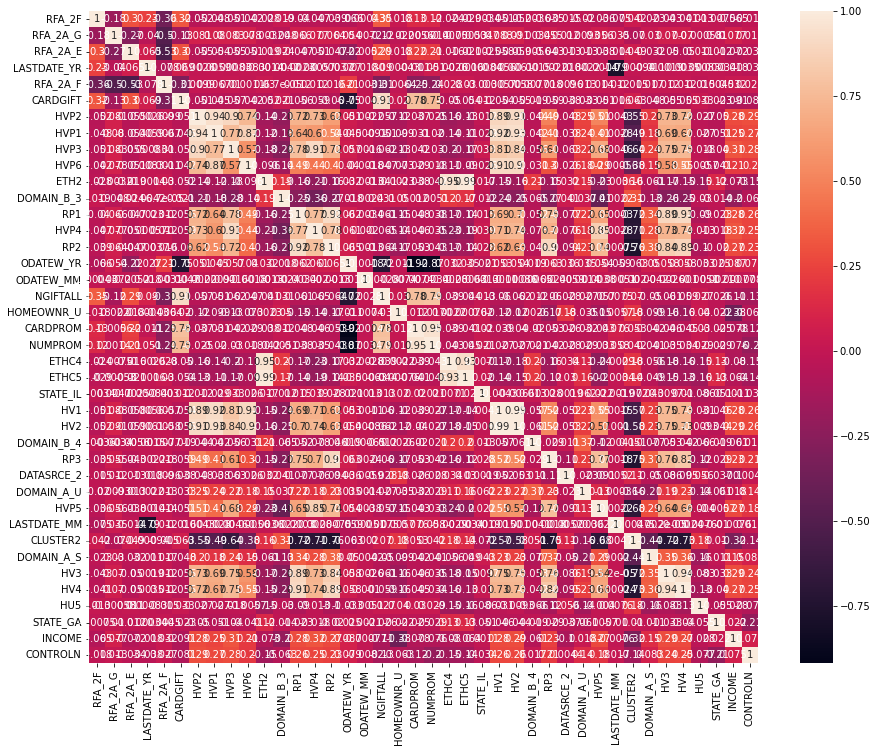

In [14]:
corr_matrix=X_train_ready[cols].corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [40]:
new_cols = []

for i in cols:
    if i not in to_drop:
        new_cols.append(i)

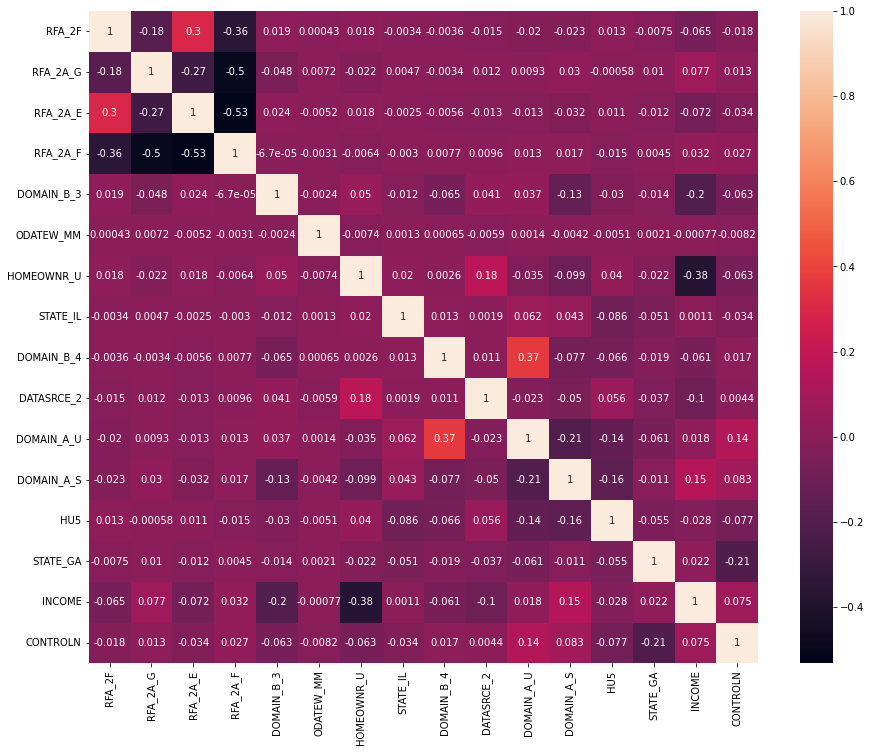

In [41]:
corr_matrix=X_train_ready[new_cols].corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [ ]:
to_drop = []

for i in range(len(cols)):
    for j in range(len(cols)):
        if (i != j) & (abs(X_train_ready[cols[i]].corr(X_train_ready[cols[j]])) > 0.7):
#             print('Variables ',cols[i],' and ',cols[j],' corr = ',str((X_train_ready[cols[i]].corr(X_train_ready[cols[j]]))))
#             print(cols[j])
            if cols[j] not in to_drop:
                to_drop.append(cols[j])
            else:
                print(cols[j])

In [37]:
to_drop

['LASTDATE_MM',
 'ODATEW_YR',
 'NGIFTALL',
 'CARDPROM',
 'NUMPROM',
 'HVP1',
 'HVP3',
 'HVP6',
 'RP1',
 'HVP4',
 'HV1',
 'HV2',
 'HV3',
 'HV4',
 'HVP2',
 'RP2',
 'ETHC4',
 'ETHC5',
 'RP3',
 'CLUSTER2',
 'HVP5',
 'CARDGIFT',
 'ETH2',
 'LASTDATE_YR']

In [ ]:
for X_column1 in fifa21.select_dtypes(np.number)[:-1]:
    for X_column2 in fifa21.select_dtypes(np.number)[:-1]:
        if X_column1 != X_column2 & abs(fifa21[X_column1].corr(fifa21[X_column2]))>0.9:
            print('Variables'+fifa21[X_column1].name+'and'+fifa21[X_column2].name+'corr = ' + str(fifa21[X_column1].corr(fifa21[X_column2])))

In [18]:
corr_matrix[corr_matrix < abs(0.7)]

,RFA_2F,RFA_2A_G,RFA_2A_E,LASTDATE_YR,RFA_2A_F,CARDGIFT,HVP2,HVP1,HVP3,HVP6,ETH2,DOMAIN_B_3,RP1,HVP4,RP2,ODATEW_YR,ODATEW_MM,NGIFTALL,HOMEOWNR_U,CARDPROM,NUMPROM,ETHC4,ETHC5,STATE_IL,HV1,HV2,DOMAIN_B_4,RP3,DATASRCE_2,DOMAIN_A_U,HVP5,LASTDATE_MM,CLUSTER2,DOMAIN_A_S,HV3,HV4,HU5,STATE_GA,INCOME,CONTROLN
RFA_2F,NaN,-0.176821,0.295842,0.233378,-0.360325,0.321785,-0.051775,-0.048370,-0.051301,-0.042390,-0.028246,0.018894,-0.040122,-0.047161,-0.039064,-0.065717,0.000428,0.346917,0.018002,0.133534,0.121948,-0.023886,-0.029417,-0.003365,-0.050922,-0.052453,-0.003580,-0.035098,-0.014678,-0.019560,-0.036253,-0.075053,0.042429,-0.022851,-0.043148,-0.040967,0.013376,-0.007467,-0.065479,-0.017696
RFA_2A_G,-0.176821,NaN,-0.273290,-0.040337,-0.498130,-0.133050,0.080892,0.079813,0.082992,0.078013,-0.003159,-0.048328,0.066319,0.076677,0.064348,0.053654,0.007182,-0.123464,-0.022290,-0.005620,0.001374,-0.007479,-0.000533,0.004720,0.088327,0.090918,-0.003401,0.055093,0.011803,0.009278,0.056294,0.034693,-0.069689,0.030002,0.069608,0.069681,-0.000576,0.009966,0.077172,0.012976
RFA_2A_E,0.295842,-0.273290,NaN,0.064804,-0.532243,0.296912,-0.055465,-0.054499,-0.054705,-0.050777,-0.019071,0.023938,-0.047332,-0.050890,-0.047418,-0.222657,-0.005204,0.290678,0.017673,0.221449,0.209988,-0.016064,-0.021095,-0.002463,-0.057880,-0.059404,-0.005646,-0.042566,-0.012918,-0.013188,-0.038087,-0.013788,0.049457,-0.032208,-0.049642,-0.049838,0.010749,-0.012026,-0.071807,-0.033809
LASTDATE_YR,0.233378,-0.040337,0.064804,NaN,-0.078239,0.068801,0.002619,0.005871,0.000832,0.008296,-0.001430,-0.004225,0.002326,0.000569,-0.000369,0.027475,0.017593,0.089861,-0.000434,-0.010892,0.050734,-0.002583,-0.001643,0.000839,0.005593,0.006062,-0.001522,-0.002157,-0.018072,0.002170,-0.001415,-0.785284,-0.000941,-0.010744,0.001882,0.003514,0.000829,0.000337,-0.017525,-0.037885
RFA_2A_F,-0.360325,-0.498130,-0.532243,-0.078239,NaN,-0.305654,0.009882,0.006700,0.010466,0.001134,0.029639,-0.000067,0.012361,0.012132,0.015713,0.214693,-0.003113,-0.305217,-0.006374,-0.252789,-0.236172,0.027925,0.030118,-0.003001,0.005672,0.005838,0.007719,0.017684,0.009606,0.013465,0.014435,0.011611,-0.014734,0.017387,0.012057,0.012311,-0.015408,0.004485,0.031644,0.026922
CARDGIFT,0.321785,-0.133050,0.296912,0.068801,-0.305654,NaN,-0.051198,-0.045298,-0.056549,-0.041800,-0.052170,0.020739,-0.056417,-0.058781,-0.060451,-0.747413,-0.004680,NaN,0.020304,NaN,NaN,-0.050111,-0.054431,0.011583,-0.054206,-0.055415,-0.019191,-0.058947,-0.038038,-0.032677,-0.051180,-0.015750,0.063495,-0.048148,-0.054827,-0.055345,0.032651,-0.023073,-0.090950,-0.081100
HVP2,-0.051775,0.080892,-0.055465,0.002619,0.009882,-0.051198,NaN,NaN,NaN,NaN,-0.141543,-0.212961,NaN,NaN,0.623502,0.051118,-0.002249,-0.056743,-0.115679,-0.036569,-0.025047,-0.162913,-0.131508,-0.011612,NaN,NaN,-0.044316,0.493272,-0.047555,0.249723,0.507687,0.004326,-0.550372,0.200213,NaN,NaN,-0.027334,-0.050411,0.279944,0.290701
HVP1,-0.048370,0.079813,-0.054499,0.005871,0.006700,-0.045298,NaN,NaN,NaN,NaN,-0.122307,-0.184033,0.639245,0.602473,0.535753,0.044903,-0.000910,-0.050676,-0.099475,-0.031345,-0.020011,-0.142522,-0.113943,-0.028961,NaN,NaN,-0.041627,0.412775,-0.038482,0.240494,0.406667,0.002755,-0.485152,0.177048,0.687374,0.674718,-0.026963,-0.051460,0.254313,0.266017
HVP3,-0.051301,0.082992,-0.054705,0.000832,0.010466,-0.056549,NaN,NaN,NaN,0.569373,-0.177659,-0.279076,NaN,NaN,NaN,0.056805,0.001640,-0.062389,-0.133727,-0.041732,-0.030074,-0.199574,-0.165123,0.033026,NaN,NaN,-0.056214,0.606068,-0.063351,0.219384,0.676094,0.004584,-0.644241,0.242877,NaN,NaN,-0.017516,-0.039514,0.310353,0.284812
HVP6,-0.042390,0.078013,-0.050777,0.008296,0.001134,-0.041800,NaN,NaN,0.569373,NaN,-0.096118,-0.139906,0.486907,0.438079,0.397212,0.039659,-0.001842,-0.047307,-0.072556,-0.028692,-0.018377,-0.113008,-0.090210,-0.026398,NaN,NaN,-0.031407,0.298701,-0.026378,0.183835,0.291152,-0.000562,-0.384841,0.151028,0.576121,0.547955,-0.005740,-0.041035,0.209259,0.199183
